# Ablation statistics

Load intervention results (`intervene.py`) and summarize ablation effects versus the stored baseline.

In [25]:
# Parameters
from pathlib import Path
import sys

SETTING = "tree"  # Options: "tree", "math"

# Tree settings
DEPTH_RANGE = [1, 2]
STEPS_RANGE = [1, 2]
NUM_SAMPLES = 1000

# Math settings (GSM8K)
GSM8K_NUM_SAMPLES = 1000
GSM8K_SEED = 0
GSM8K_SPLIT = "all"  # Options: "train", "test", "all"

def _parse_range(values, name: str, min_value: int = 1) -> tuple[int, int]:
    if isinstance(values, (int, float)):
        values = [int(values)]
    if len(values) == 1:
        range_min = range_max = int(values[0])
    elif len(values) == 2:
        range_min, range_max = [int(v) for v in values]
    else:
        raise ValueError(f"{name} must have 1 or 2 integers")
    if range_min < min_value or range_max < min_value or range_max < range_min:
        raise ValueError(f"{name} must be >= {min_value} and max >= min")
    return range_min, range_max


def _format_steps_tag(num_steps) -> str:
    if isinstance(num_steps, (list, tuple)):
        if len(num_steps) != 2:
            raise ValueError("num_steps must have 1 or 2 integers")
        min_steps, max_steps = num_steps
    else:
        min_steps = max_steps = int(num_steps)
    if min_steps == max_steps == 1:
        return ""
    if min_steps == max_steps:
        return f"_steps{min_steps}"
    return f"_steps{min_steps}-{max_steps}"


def _tree_dataset_tag(min_depth: int, max_depth: int, num_samples: int, num_steps) -> str:
    suffix = f"n{num_samples}" if num_samples > 0 else "nall"
    steps = _format_steps_tag(num_steps)
    return f"depth{min_depth}-{max_depth}_{suffix}{steps}"


def _gsm8k_dataset_tag(num_samples: int, seed: int, split: str) -> str:
    split_tag = (split or "all").lower()
    sample_tag = "nall" if num_samples <= 0 else f"n{num_samples}"
    if split_tag == "all":
        return f"gsm8k_{sample_tag}_seed{seed}"
    return f"gsm8k_{split_tag}_{sample_tag}_seed{seed}"


def _intervention_tag(answer_only: bool, layer_sweep: bool) -> str:
    parts = []
    if answer_only:
        parts.append("answeronly")
    if layer_sweep:
        parts.append("layersweep")
    return f"_{'_'.join(parts)}" if parts else ""


if SETTING == "math":
    DATASET_TAG = _gsm8k_dataset_tag(GSM8K_NUM_SAMPLES, GSM8K_SEED, GSM8K_SPLIT)
else:
    MIN_DEPTH, MAX_DEPTH = _parse_range(DEPTH_RANGE, "depth-range", min_value=1)
    MIN_STEPS, MAX_STEPS = _parse_range(STEPS_RANGE, "steps-range", min_value=1)
    STEPS_TAG = (MIN_STEPS, MAX_STEPS) if MIN_STEPS != MAX_STEPS else MIN_STEPS
    DATASET_TAG = _tree_dataset_tag(MIN_DEPTH, MAX_DEPTH, NUM_SAMPLES, STEPS_TAG)

MODEL_TAG = "DeepSeek-R1-Distill-Qwen-14B"
PROJ_DIM = 5
PCA_COMPONENTS = 10
LAYER = 31

# Top section: standard ablation results (non-answer-only)
BUCKET = "exact"  # Options: "all", "exact", "partial", "zero"

RESULTS_PATH = Path(
    f"../data/{DATASET_TAG}/models/{MODEL_TAG}/interventions/interventions_proj{PROJ_DIM}_pca{PCA_COMPONENTS}_layer{LAYER}.npz"
)
if not RESULTS_PATH.exists():
    legacy = Path(
        f"../data/{DATASET_TAG}/models/{MODEL_TAG}/interventions/interventions_proj{PROJ_DIM}_layer{LAYER}.npz"
    )
    if legacy.exists():
        RESULTS_PATH = legacy

# Bottom section: answer-only layer-sweep results
LAYER_SWEEP = True
ANSWER_ONLY = True
LAYER_SWEEP_PATH = Path(
    f"../data/{DATASET_TAG}/models/{MODEL_TAG}/interventions/interventions_proj{PROJ_DIM}_pca{PCA_COMPONENTS}_layerall{_intervention_tag(ANSWER_ONLY, LAYER_SWEEP)}.npz"
)
if not LAYER_SWEEP_PATH.exists():
    legacy = Path(
        f"../data/{DATASET_TAG}/models/{MODEL_TAG}/interventions/interventions_proj{PROJ_DIM}_layerall{_intervention_tag(ANSWER_ONLY, LAYER_SWEEP)}.npz"
    )
    if legacy.exists():
        LAYER_SWEEP_PATH = legacy

NOTEBOOK_DIR = Path.cwd().resolve()
for candidate in [NOTEBOOK_DIR, *NOTEBOOK_DIR.parents]:
    if (candidate / "cutter").exists():
        PROJECT_ROOT = candidate
        break
else:
    raise RuntimeError("Could not locate repository root containing cutter/")
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

In [26]:
# Load results
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Palette aligned with probe-statistics
PROBE_COLOR = '#1d4ed8'  # stronger blue
RANDOM_COLOR = '#d1d5db'  # lightest gray
FULL_PCA_COLOR = '#bfc5cd'  # light gray
PCA_COLOR = '#949aa7'  # mid gray
ZERO_COLOR = '#5a6472'  # darkest gray
BASELINE_COLOR = '#949aa7'  # mid gray

npz = np.load(RESULTS_PATH, allow_pickle=True)
meta = npz['meta'].item()
aggregate = npz['aggregate'].item()
records = npz['records'].tolist()

rows = []
for rec in records:
    base = rec['baseline']
    probe = rec['probe_ablation']
    pca = rec.get('pca_ablation', {})
    full_pca = rec.get('full_pca_ablation', {})
    zero = rec.get('zero_ablation', {})
    rand = rec['random_ablation'][0] if rec.get('random_ablation') else {}
    rows.append({
        'example_id': rec.get('example_id'),
        'depth': rec.get('depth'),
        'baseline_exact': bool(base.get('exact_match')),
        'baseline_partial': float(base.get('partial_score', 0.0)),
        'probe_exact': bool(probe.get('exact_match')),
        'probe_partial': float(probe.get('partial_score', 0.0)),
        'probe_logit_diff': float(probe.get('logit_diff', np.nan)),
        'pca_exact': bool(pca.get('exact_match', False)),
        'pca_partial': float(pca.get('partial_score', np.nan)),
        'pca_logit_diff': float(pca.get('logit_diff', np.nan)),
        'full_pca_exact': bool(full_pca.get('exact_match', False)),
        'full_pca_partial': float(full_pca.get('partial_score', np.nan)),
        'full_pca_logit_diff': float(full_pca.get('logit_diff', np.nan)),
        'zero_exact': bool(zero.get('exact_match', False)),
        'zero_partial': float(zero.get('partial_score', np.nan)),
        'zero_logit_diff': float(zero.get('logit_diff', np.nan)),
        'rand_exact': bool(rand.get('exact_match', False)),
        'rand_partial': float(rand.get('partial_score', np.nan)),
        'rand_logit_diff': float(rand.get('logit_diff', np.nan)),
    })
df = pd.DataFrame(rows)
df['probe_delta_exact'] = df['probe_exact'].astype(int) - df['baseline_exact'].astype(int)
df['pca_delta_exact'] = df['pca_exact'].astype(int) - df['baseline_exact'].astype(int)
df['full_pca_delta_exact'] = df['full_pca_exact'].astype(int) - df['baseline_exact'].astype(int)
df['zero_delta_exact'] = df['zero_exact'].astype(int) - df['baseline_exact'].astype(int)
df['rand_delta_exact'] = df['rand_exact'].astype(int) - df['baseline_exact'].astype(int)
df['probe_delta_partial'] = df['probe_partial'] - df['baseline_partial']
df['pca_delta_partial'] = df['pca_partial'] - df['baseline_partial']
df['full_pca_delta_partial'] = df['full_pca_partial'] - df['baseline_partial']
df['zero_delta_partial'] = df['zero_partial'] - df['baseline_partial']
df['rand_delta_partial'] = df['rand_partial'] - df['baseline_partial']
df['bucket'] = np.where(df['baseline_exact'], 'baseline_exact', np.where(df['baseline_partial'] > 0, 'baseline_partial_only', 'baseline_zero'))

# Filter by selected bucket
bucket_map = {
    'exact': 'baseline_exact',
    'partial': 'baseline_partial_only',
    'zero': 'baseline_zero',
    'all': None
}
if BUCKET not in bucket_map:
    raise ValueError(f"BUCKET must be one of {list(bucket_map.keys())}, got '{BUCKET}'")
if bucket_map[BUCKET] is not None:
    bucket_label = bucket_map[BUCKET].replace('baseline_', '').replace('_only', '')
else:
    bucket_label = 'all examples'
if BUCKET not in bucket_map:
    raise ValueError(f"BUCKET must be one of {list(bucket_map.keys())}, got '{BUCKET}'")
if bucket_map[BUCKET] is not None:
    df = df[df['bucket'] == bucket_map[BUCKET]].copy()
    bucket_label = bucket_map[BUCKET].replace('baseline_', '').replace('_only', '')
else:
    bucket_label = 'all examples'

print(f"Selected bucket: {BUCKET} ({bucket_label})")
print(f"Number of examples: {len(df)}")
df.head()

Selected bucket: exact (exact)
Number of examples: 443


,example_id,depth,baseline_exact,baseline_partial,probe_exact,probe_partial,probe_logit_diff,pca_exact,pca_partial,pca_logit_diff,...,pca_delta_exact,full_pca_delta_exact,zero_delta_exact,rand_delta_exact,probe_delta_partial,pca_delta_partial,full_pca_delta_partial,zero_delta_partial,rand_delta_partial,bucket
0,0,1,True,1.0,True,1.0,1.683838,True,1.000000,3.688721,...,0,0,-1,0,0.0,0.000000,0.0,-1.0,0.0,baseline_exact
1,2,2,True,1.0,True,1.0,2.170329,False,0.333333,5.464925,...,-1,0,-1,0,0.0,-0.666667,0.0,-1.0,0.0,baseline_exact
2,4,2,True,1.0,False,0.0,1.964966,False,0.000000,5.534912,...,-1,0,-1,0,-1.0,-1.000000,0.0,-1.0,0.0,baseline_exact
3,5,2,True,1.0,True,1.0,1.611572,False,0.000000,4.739990,...,-1,-1,-1,0,0.0,-1.000000,-1.0,-1.0,0.0,baseline_exact
4,7,2,True,1.0,True,1.0,1.537842,True,1.000000,4.253174,...,0,0,-1,0,0.0,0.000000,0.0,-1.0,0.0,baseline_exact


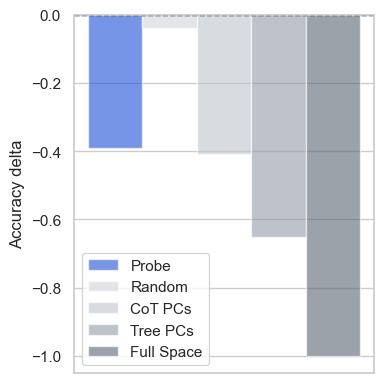

In [27]:
# Accuracy deltas
def bucket_deltas(sub):
    baseline_exact_rate = sub['baseline_exact'].mean()
    baseline_partial_mean = sub['baseline_partial'].mean()
    return {
        'count': len(sub),
        'probe_exact_delta': sub['probe_exact'].mean() - baseline_exact_rate,
        'pca_exact_delta': sub['pca_exact'].mean() - baseline_exact_rate,
        'full_pca_exact_delta': sub['full_pca_exact'].mean() - baseline_exact_rate,
        'zero_exact_delta': sub['zero_exact'].mean() - baseline_exact_rate,
        'rand_exact_delta': sub['rand_exact'].mean() - baseline_exact_rate,
        'probe_partial_delta': sub['probe_partial'].mean() - baseline_partial_mean,
        'pca_partial_delta': sub['pca_partial'].mean() - baseline_partial_mean,
        'full_pca_partial_delta': sub['full_pca_partial'].mean() - baseline_partial_mean,
        'zero_partial_delta': sub['zero_partial'].mean() - baseline_partial_mean,
        'rand_partial_delta': sub['rand_partial'].mean() - baseline_partial_mean,
    }

def plot_delta_bars(label: str, stats: dict, save=False):
    fig, ax = plt.subplots(figsize=(4, 4))
    # Only show partial accuracy
    probe_val = stats['probe_partial_delta']
    rand_val = stats['rand_partial_delta']
    pca_val = stats['pca_partial_delta']
    full_pca_val = stats['full_pca_partial_delta']
    zero_val = stats['zero_partial_delta']

    bars = [
        (probe_val, 'Probe', PROBE_COLOR),
        (rand_val, 'Random', RANDOM_COLOR),
        (full_pca_val, 'CoT PCs', FULL_PCA_COLOR),
        (pca_val, 'Tree PCs', PCA_COLOR),
        (zero_val, 'Full Space', ZERO_COLOR),
    ]
    bars = [b for b in bars if not np.isnan(b[0])]
    x = np.arange(1)
    width = 0.18
    offsets = np.linspace(-width * (len(bars) - 1) / 2, width * (len(bars) - 1) / 2, len(bars))
    for offset, (val, label, color) in zip(offsets, bars):
        ax.bar(x + offset, val, width, label=label, color=color, alpha=0.6)
    ax.axhline(0, color='black', linewidth=1, linestyle='--')
    ax.set_xticks([])
    ax.set_ylabel('Accuracy delta')
    ax.legend()
    plt.tight_layout()
    if save:
        plt.savefig(PROJECT_ROOT / 'cutter/figures/paper/ablation-statistics.png', dpi=300)
    plt.show()

plot_delta_bars(bucket_label, bucket_deltas(df), save=False)

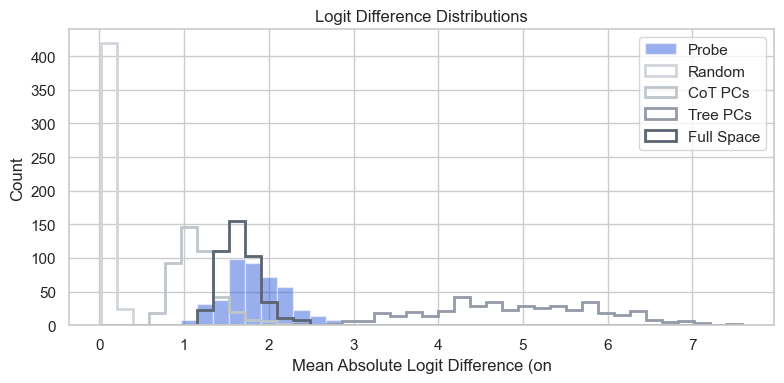

In [28]:
# Logit difference distributions
probe_vals = df['probe_logit_diff'].dropna()
pca_vals = df['pca_logit_diff'].dropna()
full_pca_vals = df['full_pca_logit_diff'].dropna() if 'full_pca_logit_diff' in df else pd.Series(dtype=float)
zero_vals = df['zero_logit_diff'].dropna()
rand_vals = df['rand_logit_diff'].dropna()
series = [probe_vals, pca_vals, zero_vals, rand_vals]
if not full_pca_vals.empty:
    series.append(full_pca_vals)
combined = pd.concat(series)
if not combined.empty:
    bins = np.histogram_bin_edges(combined, bins=40)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(probe_vals, bins=bins, alpha=0.45, label='Probe', color=PROBE_COLOR)
    ax.hist(rand_vals, bins=bins, histtype='step', linewidth=2, label='Random', color=RANDOM_COLOR)
    if not full_pca_vals.empty:
        ax.hist(full_pca_vals, bins=bins, histtype='step', linewidth=2, label='CoT PCs', color=FULL_PCA_COLOR)
    ax.hist(pca_vals, bins=bins, histtype='step', linewidth=2, label='Tree PCs', color=PCA_COLOR)
    ax.hist(zero_vals, bins=bins, histtype='step', linewidth=2, label='Full Space', color=ZERO_COLOR)
    ax.set_xlabel('Mean Absolute Logit Difference (on')
    ax.set_ylabel('Count')
    ax.set_title(f'Logit Difference Distributions')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print('No logit differences available to plot.')

**Report statistics about the logit difference distributions**
1. Common language effect size:
$P(\Delta_{\text{probe}} > \Delta_{\text{random}})$
2. Wasserstein-1 distance (with bootstrap CI)
3. Median difference (robust location shift)

In [29]:
import numpy as np
from scipy.stats import wasserstein_distance

probe_vals = df['probe_logit_diff'].dropna().to_numpy()
rand_vals = df['rand_logit_diff'].dropna().to_numpy()

if len(probe_vals) == 0 or len(rand_vals) == 0:
    print(f"No logit difference data available for bucket '{bucket_label}'.")
else:
    def common_language_effect(a: np.ndarray, b: np.ndarray) -> float:
        """Monte Carlo probability that probe exceeds random."""
        return np.greater.outer(a, b).mean()

    def bootstrap_wasserstein(a: np.ndarray, b: np.ndarray, n_boot: int = 1000, seed: int = 0):
        rng = np.random.default_rng(seed)
        stats = []
        for _ in range(n_boot):
            a_samp = rng.choice(a, size=a.size, replace=True)
            b_samp = rng.choice(b, size=b.size, replace=True)
            stats.append(wasserstein_distance(a_samp, b_samp))
        stats = np.array(stats)
        return float(stats.mean()), tuple(np.percentile(stats, [2.5, 97.5]))

    common_lang = common_language_effect(probe_vals, rand_vals)
    wasserstein_mean, (w_lo, w_hi) = bootstrap_wasserstein(probe_vals, rand_vals)
    median_shift = float(np.median(probe_vals) - np.median(rand_vals))

    print(f"Logit difference distribution statistics | {bucket_label} (n={len(df)})")
    print(f"  Common language effect P(probe > random): {common_lang:.3f}")
    print(f"  Wasserstein-1 distance: {wasserstein_mean:.3f} (95% CI [{w_lo:.3f}, {w_hi:.3f}])")
    print(f"  Median difference (probe - random): {median_shift:.3f}")

Logit difference distribution statistics | exact (n=443)
  Common language effect P(probe > random): 1.000
  Wasserstein-1 distance: 1.744 (95% CI [1.709, 1.779])
  Median difference (probe - random): 1.722


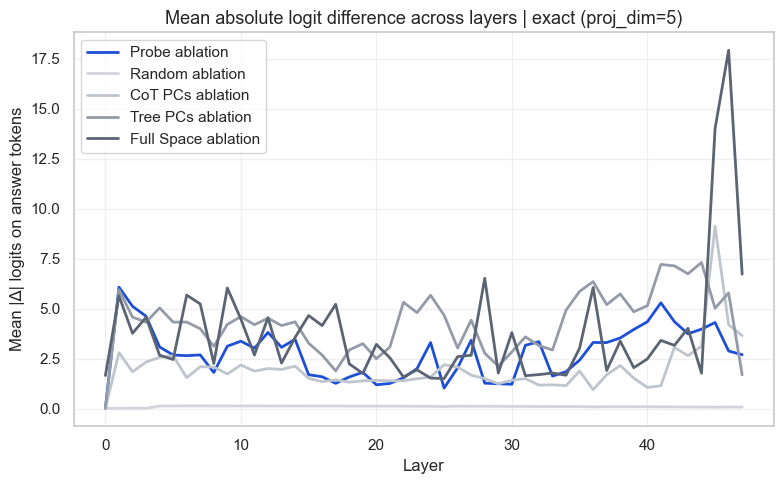

In [30]:
# Layer sweep: mean logit differences across layers (answer-only)
if not LAYER_SWEEP_PATH.exists():
    raise FileNotFoundError(f"Layer-sweep file not found: {LAYER_SWEEP_PATH}")

npz_layer = np.load(LAYER_SWEEP_PATH, allow_pickle=True)

layers = []
probe_means = []
pca_means = []
full_pca_means = []
zero_means = []
random_means = []

bucket_map = {
    'exact': 'baseline_exact',
    'partial': 'baseline_partial_only',
    'zero': 'baseline_zero',
    'all': None
}

if BUCKET not in bucket_map:
    raise ValueError(f"BUCKET must be one of {list(bucket_map.keys())}, got '{BUCKET}'")
if bucket_map[BUCKET] is not None:
    bucket_label = bucket_map[BUCKET].replace('baseline_', '').replace('_only', '')
else:
    bucket_label = 'all examples'

records = npz_layer['records'].tolist()
for entry in records:
    layer = int(entry.get('layer'))
    layer_records = entry.get('records', [])
    rows = []
    for rec in layer_records:
        base = rec['baseline']
        probe = rec['probe_ablation']
        pca = rec.get('pca_ablation', {})
        full_pca = rec.get('full_pca_ablation', {})
        zero = rec.get('zero_ablation', {})
        random_runs = rec.get('random_ablation', [])
        if random_runs:
            rand_logit_diffs = [float(r.get('logit_diff', np.nan)) for r in random_runs]
            rand_logit_mean = np.nanmean(rand_logit_diffs) if rand_logit_diffs else np.nan
        else:
            rand_logit_mean = np.nan
        rows.append({
            'example_id': rec.get('example_id'),
            'depth': rec.get('depth'),
            'baseline_exact': bool(base.get('exact_match')),
            'baseline_partial': float(base.get('partial_score', 0.0)),
            'probe_logit_diff': float(probe.get('logit_diff', np.nan)),
            'pca_logit_diff': float(pca.get('logit_diff', np.nan)),
            'full_pca_logit_diff': float(full_pca.get('logit_diff', np.nan)),
            'zero_logit_diff': float(zero.get('logit_diff', np.nan)),
            'rand_logit_diff': rand_logit_mean,
        })
    df_layer = pd.DataFrame(rows)
    df_layer['bucket'] = np.where(
        df_layer['baseline_exact'],
        'baseline_exact',
        np.where(df_layer['baseline_partial'] > 0, 'baseline_partial_only', 'baseline_zero')
    )
    if bucket_map[BUCKET] is not None:
        df_layer = df_layer[df_layer['bucket'] == bucket_map[BUCKET]].copy()
    if df_layer.empty:
        continue

    layers.append(layer)
    probe_means.append(float(np.nanmean(df_layer['probe_logit_diff'])))
    pca_means.append(float(np.nanmean(df_layer['pca_logit_diff'])))
    full_pca_means.append(float(np.nanmean(df_layer['full_pca_logit_diff'])))
    zero_means.append(float(np.nanmean(df_layer['zero_logit_diff'])))
    random_means.append(float(np.nanmean(df_layer['rand_logit_diff'])))

# Create plot
if layers:
    order = np.argsort(layers)
    layers = list(np.array(layers)[order])
    probe_means = list(np.array(probe_means)[order])
    pca_means = list(np.array(pca_means)[order])
    full_pca_means = list(np.array(full_pca_means)[order])
    zero_means = list(np.array(zero_means)[order])
    random_means = list(np.array(random_means)[order])

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(layers, probe_means, label='Probe ablation', color=PROBE_COLOR, linewidth=2, markersize=8)
    ax.plot(layers, random_means, label='Random ablation', color=RANDOM_COLOR, linewidth=2, markersize=8)
    if any(not np.isnan(x) for x in full_pca_means):
        ax.plot(layers, full_pca_means, label='CoT PCs ablation', color=FULL_PCA_COLOR, linewidth=2, markersize=8)
    if any(not np.isnan(x) for x in pca_means):
        ax.plot(layers, pca_means, label='Tree PCs ablation', color=PCA_COLOR, linewidth=2, markersize=8)
    if any(not np.isnan(x) for x in zero_means):
        ax.plot(layers, zero_means, label='Full Space ablation', color=ZERO_COLOR, linewidth=2, markersize=8)
    ax.set_xlabel('Layer', fontsize=12)
    ax.set_ylabel('Mean |Δ| logits on answer tokens', fontsize=12)
    ax.set_title(f"Mean absolute logit difference across layers | {bucket_label} (proj_dim={PROJ_DIM})", fontsize=13)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('No data available for any layers in the layer-sweep file.')